KNN:

Accuracy:  0.7804878048780488
F1 Score:  0.5263157894736842
Confusion Matrix: 
 [[27  3]
 [ 6  5]]


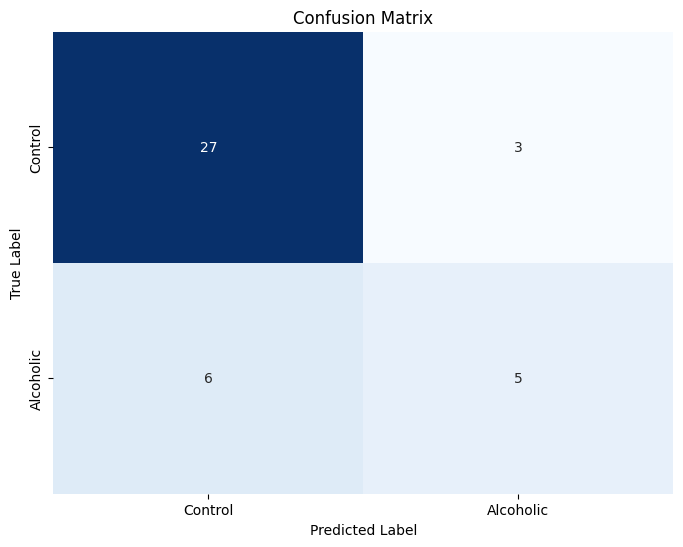

In [51]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.spatial.distance import euclidean
import seaborn as sns

class KNearestNeighbors:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _compute_distances(self, X_test_instance):
        distances = [euclidean(X_test_instance, x_train) for x_train in self.X_train]
        return distances

    def _get_neighbors(self, X_test_instance):
        distances = self._compute_distances(X_test_instance)
        sorted_indices = np.argsort(distances)
        k_nearest_indices = sorted_indices[:self.k]
        return k_nearest_indices

    def predict(self, X_test):
        y_pred = []
        for test_instance in X_test:
            neighbors_indices = self._get_neighbors(test_instance)
            k_nearest_labels = [self.y_train[i] for i in neighbors_indices]
            # Determinar la clase mayoritaria entre los vecinos
            majority_label = Counter(k_nearest_labels).most_common(1)[0][0]
            y_pred.append(majority_label)
        return np.array(y_pred)
    def set_params(self, **params):
        self.k = params.get('k', self.k)
        return self


# 1. Cargar los datos de EEG
import h5py
with h5py.File('./train.h5', 'r') as file:
    eeg_data = file['x'][:]  # Datos de EEG
    labels = file['y'][:]    # Etiquetas (alcohólico o control)

# 2. Aplicar BOSS
n_bins = 4
from pyts.transformation import BOSS
boss = BOSS(n_bins=n_bins)
X_transformed = boss.fit_transform(eeg_data[:, 0, :eeg_data.shape[2]], labels)

# 3. Dividir datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, labels, test_size=0.2, random_state=42)

# 4. Aplicar PCA para reducción de dimensionalidad
from sklearn.decomposition import PCA
pca = PCA(n_components=30)#4 , 30 ,3 = 0.52
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 5. Entrenar el modelo KNN
knn = KNearestNeighbors(k=3)
knn.fit(X_train_pca, y_train)

# 6. Realizar predicciones
y_pred = knn.predict(X_test_pca)

# 7. Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Confusion Matrix: \n", conf_matrix)
# 8. Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Control', 'Alcoholic'], yticklabels=['Control', 'Alcoholic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()